# Projekt zespołowy 2020/2021

## Opis zbioru danych
W niniejszy projekcie przedstawiamy analizę cen ubezpieczeń medycznych w Stanach Zjednoczonych. Do analizy użyliśmy zbioru [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance). Zbiór zawiera dane personalne osób podlegających ubezpieczeniu zdrowotnemu wraz z jego kosztem. Składa się z 1338 wierszy oraz 7 kolumn:
- **age** - wiek ubezpieczonego - **wartość liczbowa, całkowita**
- **sex** - płeć ubezpieczonego - **kolumna kategoryczna reprezentowana przez ciąg znaków: "female" / "male"**
- **bmi** - BMI ubezpieczonego, czyli wskaźnik masy ciała (ang. *body mass index*) - współczynnik powstały przez podzielenie masy ciała podanej w kilogramach przez kwadrat wysokości podanej w metrach; oznaczanie wskaźnika masy ciała ma znaczenie w ocenie zagrożenia chorobami związanymi z nadwagą i otyłością; przyjmuje się, że wyższe wartość BMI wiążą się ze zwiększonym ryzykiem dla zdrowia i życia - **wartość liczbowa, zmiennoprzecinkowa**
- **children** - liczba dzieci objętych ubezpieczeniem zdrowotnym - **wartość liczbowa, całkowita**
- **smoker** - określa czy osoba jest paląca czy nie - **kolumna kategoryczna reprezentowana przez ciąg znaków: "yes" / "no"**
- **region** - region zamieszkania ubezpieczonego - **kolumna kategoryczna reprezentowana przez ciąg znaków: "northeast" / "southeast" / "southwest" / "northwest"**
- **charges** - cena ubezpieczenia - **wartość liczbowa, zmiennoprzecinkowa**


## Cel badań
Celem jaki przed sobą stawiamy jest przygotowanie modelu regresji wykorzystującego dane dostępne w opisanym zbiorze, który będzie potrafił wyznaczyć cenę ubezpieczenia ***dla 90% przypadków testowych z błędem mniejszym niż 5%***. 


In [100]:
# Wyczanie pakietów podstawowych
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [240]:
# Wczytanie danych
dtype_dict = {'age':int,'sex':str,'bmi':float,'children':int,'smoker':str,'region':str,'charges':float}
ubez = pd.read_csv("insurance.csv", sep=',', dtype=dtype_dict)
ubez

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Przekształcenie danych
W oryginalnym zbiorze danych przekształcone zostały 3 kolumny, w następujący sposób:
- **sex** - ciąg znaków został zmieniony na typ logiczny - *true/false* - w wyniku czego powstała nowa kolumna **isMale**, dla której *true* oznacza, że dana osoba jest mężczyzną, a *false* - kobietą
- **smoker** - ciąg znaków został zmieniony na typ logiczny - *true/false* - w wyniku czego, ciąg znaków "yes" zamieniono na wartość boolowską *true*, a ciąg znaków "no" na wartość *false*
- **region** - typ kategoryczny składający się z 4 kategorii reprezentowanych przez ciąg znaków został rozbity na 2 oddzielne kolumny określające zamieszkanie pod względem kierunków północ-południe oraz wschód-zachód:
    - ***isNorth*** - określa czy osoba ubezpieczona mieszka na północy czy południu - *true* - północ, *false* - południe 
    - ***isWest*** - określa czy osoba ubezpieczona mieszka na wschodzie czy zachodzie - *true* - zachód, *false* - wschód


In [241]:
# Konwersja danych jakościowych na ilościowe
ubez.loc[:, ('isMale')] = ubez.loc[:, ('sex')].apply(lambda x: x=='male')
ubez.loc[:, ('smoker')] = ubez.loc[:, ('smoker')].apply(lambda x: x=='yes')
ubez.loc[:, ('isNorth')] = ubez.loc[:, ('region')].apply(lambda x: x.startswith('north'))
ubez.loc[:, ('isWest')] = ubez.loc[:, ('region')].apply(lambda x: x.endswith('west'))

ubez = ubez.astype({
    "isMale": 'int32',
    "smoker": 'int32',
    "isNorth": 'int32',
    "isWest": 'int32'
})

# Usunięcie danych jakościowych
ubez = ubez.drop(['sex','region'],axis=1)
ubez

,age,bmi,children,smoker,charges,isMale,isNorth,isWest
0,19,27.900,0,1,16884.92400,0,0,1
1,18,33.770,1,0,1725.55230,1,0,0
2,28,33.000,3,0,4449.46200,1,0,0
3,33,22.705,0,0,21984.47061,1,1,1
4,32,28.880,0,0,3866.85520,1,1,1
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0,10600.54830,1,1,1
1334,18,31.920,0,0,2205.98080,0,1,0
1335,18,36.850,0,0,1629.83350,0,0,0
1336,21,25.800,0,0,2007.94500,0,0,1


### Podział danych 

In [242]:
koszty = ubez['charges']
ubez.drop('charges', axis=1, inplace=True)
ubez_train, ubez_test, koszty_train, koszty_test = train_test_split(ubez, koszty, test_size=0.33, random_state=0)
cechy = ubez.columns.values
print(ubez_train.shape, koszty_train.shape, ubez_test.shape, koszty_test.shape)
cechy 

(896, 7) (896,) (442, 7) (442,)


array(['age', 'bmi', 'children', 'smoker', 'isMale', 'isNorth', 'isWest'],
      dtype=object)

## Zadanie 1
Dokonaj analizy posiadanych zmiennych. Zakresy zmienności, korelacje, skośność.

### age - wiek
- Średnia jest w przybliżeniu równa medianie, można więc przyjąć, że wykres jest symetryczny.
- Zakres danych: 14-64

count    896.000000
mean      39.497768
std       14.000957
min       18.000000
25%       27.000000
50%       40.000000
75%       52.000000
max       64.000000
Name: age, dtype: float64

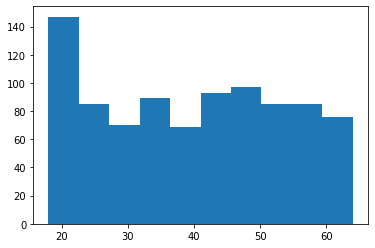

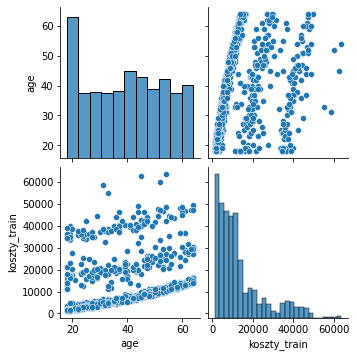

In [243]:
plt.hist(ubez_train["age"])
display(ubez_train["age"].describe())

df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### isMale - czy osoba jest mężczyzną
- Zwraca true jeśli osoba jest mężczyzną, a false jeśli kobietą.
- W bazie figuruje 454 mężczyzn i 442 kobiety.

In [244]:
ubez_train["isMale"].describe()

count    896.000000
mean       0.493304
std        0.500234
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: isMale, dtype: float64

### bmi 
- BMI czyli współczynnik powstały przez podzielenie masy ciała podanej w kilogramach przez kwadrat wysokości podanej w metrach.
- Przyjmuje się, że wyższe wartość BMI wiążą się ze zwiększonym ryzykiem dla zdrowia i życia.
- Średnia jest w przybliżeniu równa medianie (30.68 ~= 30.23, std = 6.17), można więc przyjąć, że wykres jest symetryczny.
- Zakres danych: 15.96-53.13

count    896.000000
mean      30.688069
std        6.176795
min       15.960000
25%       26.272500
50%       30.230000
75%       34.777500
max       53.130000
Name: bmi, dtype: float64

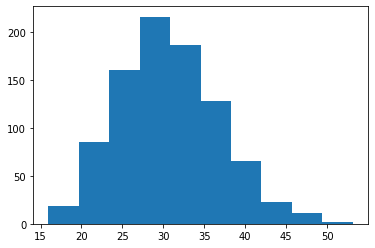

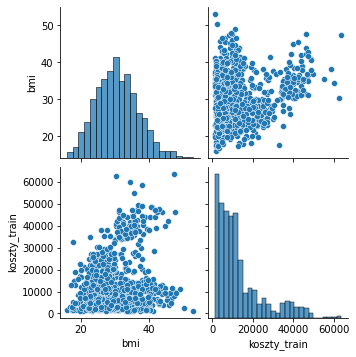

In [245]:
plt.hist(ubez_train["bmi"])
display(ubez_train["bmi"].describe())

df = pd.DataFrame(data={
    'bmi': ubez_train.loc[:, ('bmi')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### children - liczba dzieci
- Średnia jest większa niż mediana co oznacza, że wykres jest prawoskośny.
- Liczba dzieci przyjmuje wartości od 0 do 5.

count    896.000000
mean       1.093750
std        1.202476
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: children, dtype: float64

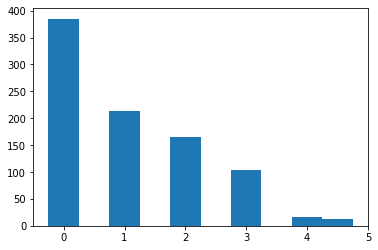

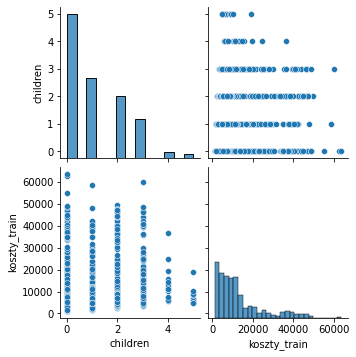

In [246]:
plt.hist(ubez_train["children"], align = "left" )
display(ubez_train["children"].describe())

df = pd.DataFrame(data={
    'children': ubez_train.loc[:, ('children')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### smoker - czy osoba jest paląca 
- Spośród 1338 ankietowanych 717 jest paląca, a 179 nie.

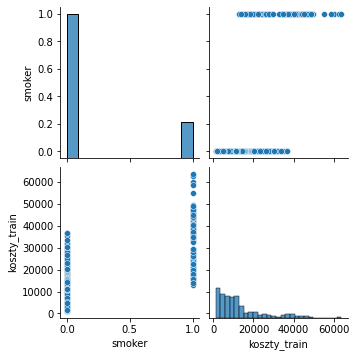

,smoker,koszty_train
smoker,1.000000,0.768143
koszty_train,0.768143,1.000000


In [247]:
ubez_train["smoker"].describe()

df = pd.DataFrame(data={
    'smoker': ubez_train.loc[:, ('smoker')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

### isWest - czy osoba mieszka na zachodzie Stanów Zjedoczonych
- Spośród 1338 ankietowanych 450 żyje na zachodzie kraju, a 436 na wschodzie.

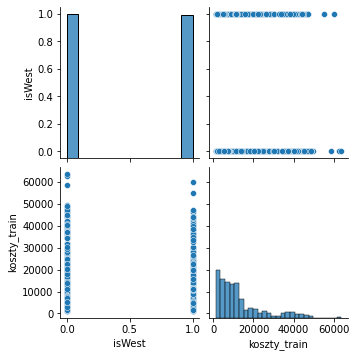

,isWest,koszty_train
isWest,1.000000,-0.098012
koszty_train,-0.098012,1.000000


In [248]:
ubez_train["isWest"].describe()

df = pd.DataFrame(data={
    'isWest': ubez_train.loc[:, ('isWest')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

### isNorth - czy osoba mieszka na północy Stanów Zjednoczonych
- Spośród 1338 ankietowanych 473 żyje na północy kraju, a 423 na południu.


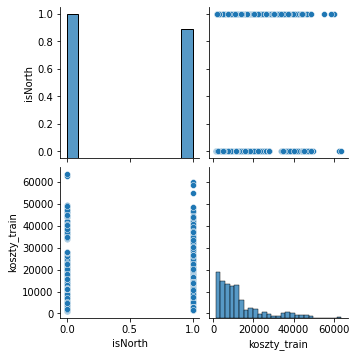

,isNorth,koszty_train
isNorth,1.000000,-0.015585
koszty_train,-0.015585,1.000000


In [249]:
ubez_train["isNorth"].describe()

df = pd.DataFrame(data={
    'isNorth': ubez_train.loc[:, ('isNorth')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

## Relacja między zmiennymi
- Korelacji W zasadzie brak
- Najwyższy współczynnik korelacji mają dane bmi or isNorth (-0.237)

,age,bmi,children,smoker,isMale,isNorth,isWest,charges
age,1.000000,0.118271,0.061732,-0.050488,-0.016912,0.035379,0.004147,0.290174
bmi,0.118271,1.000000,0.020976,-0.031631,0.020418,-0.237132,-0.138863,0.177120
children,0.061732,0.020976,1.000000,0.014444,0.008475,-0.017963,0.041210,0.089397
smoker,-0.050488,-0.031631,0.014444,1.000000,0.070899,-0.008418,-0.084302,0.768143
isMale,-0.016912,0.020418,0.008475,0.070899,1.000000,0.001487,-0.031313,0.050838
isNorth,0.035379,-0.237132,-0.017963,-0.008418,0.001487,1.000000,0.024343,-0.015585
isWest,0.004147,-0.138863,0.041210,-0.084302,-0.031313,0.024343,1.000000,-0.098012
charges,0.290174,0.177120,0.089397,0.768143,0.050838,-0.015585,-0.098012,1.000000


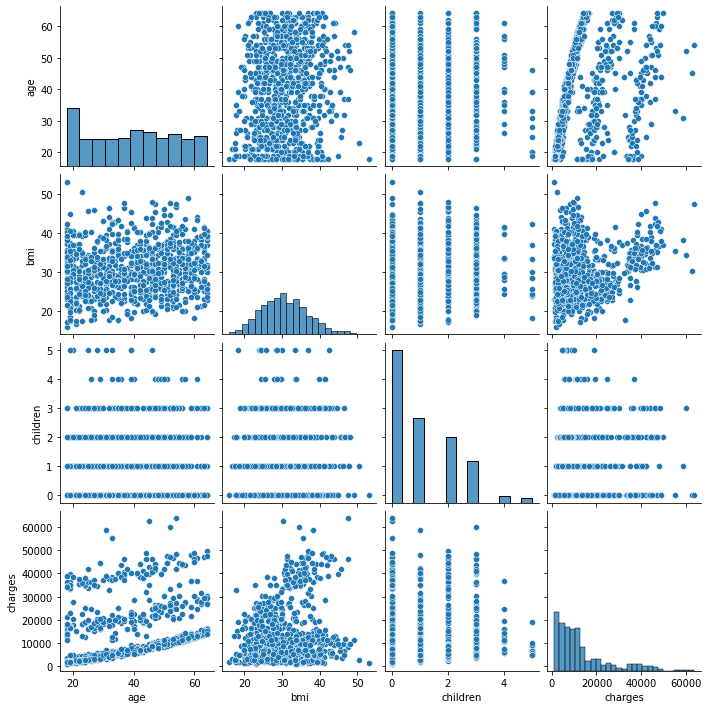

In [250]:
ubez_analysis = ubez_train.copy()
ubez_analysis.loc[:,'charges'] = koszty_train

display(ubez_analysis.corr())
sns.pairplot(ubez_analysis[["age","bmi","children","charges"]]);

## Postawienie tezy badawczej
??? Na podstawie posiadanych cech, możliwe jest wyznaczenie ceny ubezpieczenia ???

## Opracowanie wsłanych cech

### bmi_abs
Wzrost BMI niekoniecznie jest czymś niegatywny. U każdego człowieka może zachodzić zarówno niedowaga jak i nadwaga.  
Z tego powodu postwała zmienna `bmi_abs` =  if `bmi`<19: abs(19-`bmi`) if `bmi` > 24: `bmi`-24 else: 0 

In [253]:
ubez_train.loc[:, ('bmi_abs')] = ubez_train.loc[:, ('bmi')].apply(lambda x: x-24 if x>24 else abs(19-x) if x<19 else 0)
ubez_test.loc[:, ('bmi_abs')] = ubez_test.loc[:, ('bmi')].apply(lambda x: x-24 if x>24 else abs(19-x) if x<19 else 0)

c:\users\jose\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


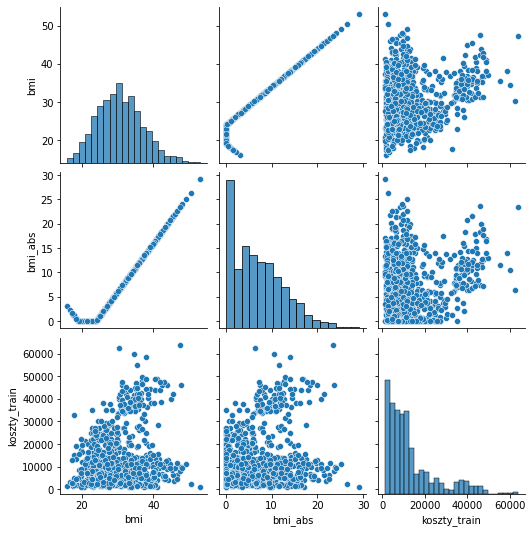

In [252]:
df = pd.DataFrame(data={
    'bmi': ubez_train.loc[:, ('bmi')],
    'bmi_abs': ubez_train.loc[:, ('bmi_abs')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### body_fatigue
Jak wiadomo, zła dieta i związana z nią waga z wiekiem osoby powoduje szybsze niszczenie organizmu.  
Z tego powodu postwała zmienna `body_fatigue` = `age` * `bmi`

In [254]:
ubez_train.loc[:, ('body_fatigue')] = ubez_train.loc[:, ('age')] * ubez_train.loc[:, ('bmi')]
ubez_test.loc[:, ('body_fatigue')] = ubez_test.loc[:, ('age')] * ubez_test.loc[:, ('bmi')]

c:\users\jose\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


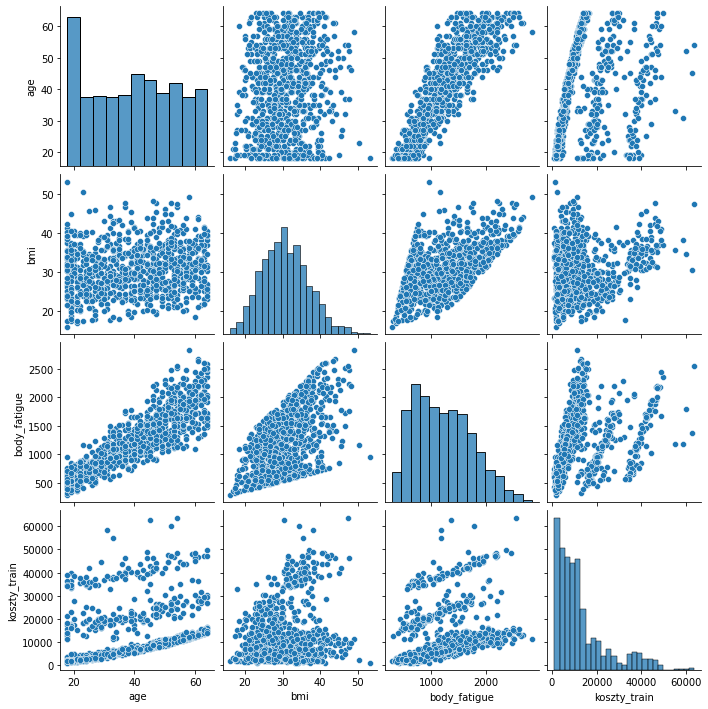

In [255]:
df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'bmi': ubez_train.loc[:, ('bmi')],
    'body_fatigue': ubez_train.loc[:, ('body_fatigue')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### smoker_bmi
Nadwagę potęguje palenie papierowsów  
Z tego powodu postwała zmienna `smoker_bmi` = `bmi` * `smoker`

In [258]:
ubez_train.loc[:, ('smoker_bmi')] = ubez_train.loc[:, ('age')] * (1+ubez_train.loc[:, ('smoker')])
ubez_test.loc[:, ('smoker_bmi')] = ubez_test.loc[:, ('age')] * (1+ubez_test.loc[:, ('smoker')])

c:\users\jose\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


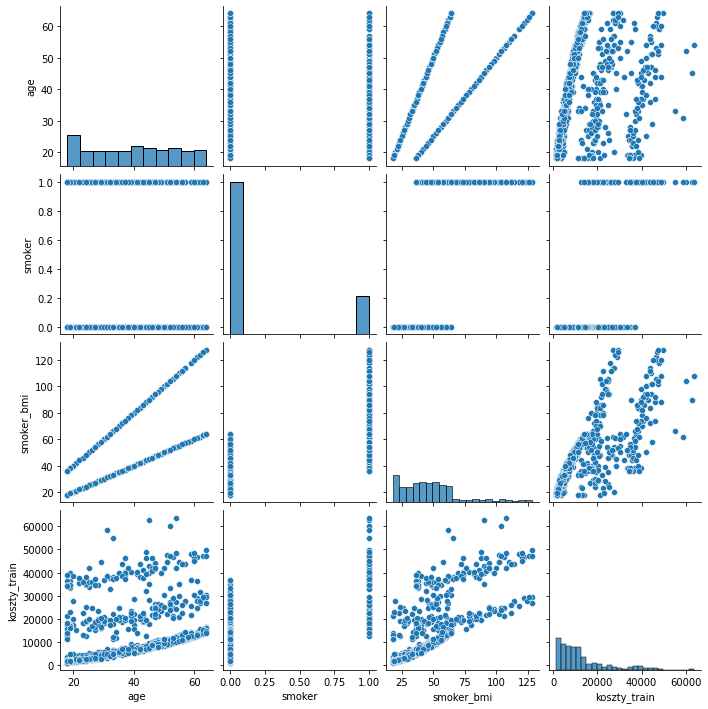

In [259]:
df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'smoker': ubez_train.loc[:, ('smoker')],
    'smoker_bmi': ubez_train.loc[:, ('smoker_bmi')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

## Wyznaczenie najbardziej znaczących cech 4 metodami

In [260]:
feature_num = 4

### 1. Forward stepwise

In [261]:
import sys

In [262]:
def regresion(X, y):
    pinw = np.linalg.pinv(X)
    return np.dot(pinw, y)

In [300]:
possible_features = ubez_train.columns
chosen_features = list()

for _ in range(feature_num):
    best_feature_rss = sys.maxsize
    best_feature_index = 0
    
    for idx, future in enumerate(possible_features):
        test_features = chosen_features.copy()
        test_features.append(future)
        
        w = regresion(ubez_train[test_features],koszty_train)
        y_pred = np.dot(ubez_test[test_features],w)
        error = koszty_test - y_pred
        rss = np.dot(error, error.T)
        
        if rss < best_feature_rss:
            best_feature_rss = rss
            best_feature_index = idx
        
    best_feature = possible_features[best_feature_index]
    chosen_features.append(best_feature)
    possible_features = np.delete(possible_features,best_feature_index)
    
    display(f"Chosen: {best_feature}, RSS: {rss}")
    
display(f"Final features: {chosen_features}")

final_features_forward_stepwise = chosen_features
final_w_forward_stepwise = regresion(ubez_train[chosen_features], koszty_train)

'Chosen: smoker_bmi, RSS: 31519287611.41449'

'Chosen: smoker, RSS: 27175590690.190674'

'Chosen: body_fatigue, RSS: 15453338469.507336'

'Chosen: age, RSS: 15394165207.04061'

"Final features: ['smoker_bmi', 'smoker', 'body_fatigue', 'age']"

### 2. Backward stepwise

In [308]:
remaining_features = ubez_train.columns

for _ in range(remaining_features.shape[0] - 4):
    wrost_feature_rss = 0
    wrost_feature_index = 0;
    
    for idx, future in enumerate(remaining_features):
        test_features = remaining_features.copy()
        test_features = np.delete(test_features,idx)
        
        w = regresion(ubez_train[test_features],koszty_train)
        y_pred = np.dot(ubez_test[test_features],w)
        error = koszty_test - y_pred
        rss = np.dot(error, error.T)
        
        if rss >= wrost_feature_rss:
            wrost_feature_rss = rss
            wrost_feature_index = idx
    
    display(f"Deleated {remaining_features[wrost_feature_index]} RSS: {wrost_feature_rss}")
    remaining_features = np.delete(remaining_features, wrost_feature_index)
    
display(f"Final features: {remaining_features}")

final_features_backward_stepwise = remaining_features
final_w_backward_stepwise = regresion(ubez_train[remaining_features], koszty_train)

'Deleated smoker RSS: 19139510106.848885'

'Deleated smoker_bmi RSS: 61636798346.71347'

'Deleated isMale RSS: 61927801731.5834'

'Deleated bmi_abs RSS: 62002151152.396095'

'Deleated body_fatigue RSS: 62492718557.73861'

'Deleated age RSS: 67553459716.46642'

"Final features: Index(['bmi', 'children', 'isNorth', 'isWest'], dtype='object')"

### 3. Lasso

In [271]:
def coordinate_descent_l1_penalty(X, y, w, lambda_ = 0.01, num_iters=100):
    m,n = X.shape
    
    # wykonujemy określoną ilość iteracji
    for _ in range(num_iters): 
        # obliczamy dla każdej kolumny odzielnie
        for j in range(n):
            # wyciany interesującą nas kolumnę
            X_j = X[:,j].reshape(-1,1)
            # wyznaczamy wartość estymowaną dla wcześniejszych współczyników
            y_pred = np.dot(X, w)
            # wyznaczamy rho
            rho = np.dot(X_j.T, (y - y_pred  + w[j]*X_j))
                
            # wykorzystujemy pewien threshold,
            # służy on abyśmy sprytnie omineli niewygodny dla nas punkt 0 gdzie nie ma pochodnej
            if rho < - lambda_:
                w[j] = rho + lambda_
            elif rho >  lambda_:
                w[j] = rho - lambda_
            else: 
                w[j] = 0
            
    return w.flatten()

'Końcowe lambda: 41943.04'

'Współczyniki:'

array([     0.        ,      0.        ,      0.        , 199549.45513141,
            0.        ,      0.        ,      0.        ,  34771.75107837,
        44431.14732238, 228895.82570284])

"Final features: Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')"

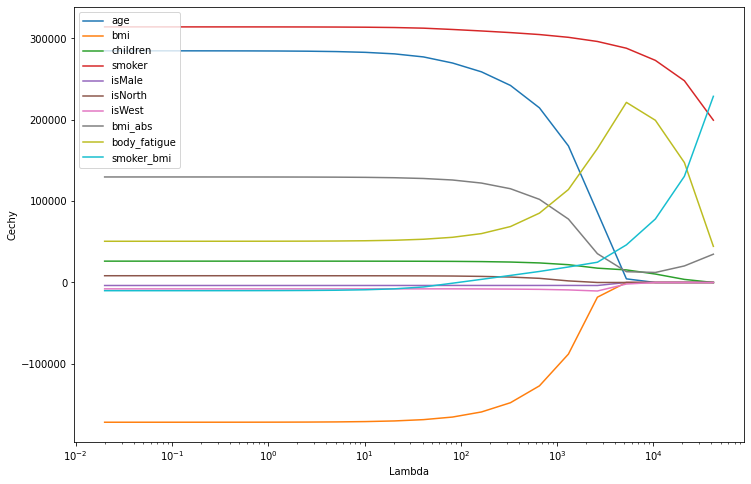

In [285]:
features_lasso = ubez_train.columns
# tworzym X oraz y
# przekształcam do numpy array, ponieważ dla typu DataFrame liczyło bardzo długo każdą z iteracji
X = ubez_train.to_numpy()
y = koszty_train.to_numpy().reshape(-1,1)

# normalizacja X
X = X / (np.linalg.norm(X,axis = 0))

lambda_list = list()
w_list = list()

# dodajemy licznik, który jest odpowiedzialny za zwiększanie kary
lambda_counter = 1
while True:
    # w każdej iteracji kara jest coraz większa
    lambda_ = 0.01*2**lambda_counter
    
    # wyznaczamy współczynniki
    w = np.zeros((features_lasso.shape[0],1))
    w = coordinate_descent_l1_penalty(X, y, w, lambda_ = lambda_, num_iters=100)
    
    lambda_list.append(lambda_)
    w_list.append(w)
    
    # jeśli zostało mniej niż 'feature_num' nieujemnych współczyników, przerwamy pętlę
    if w.nonzero()[0].shape[0] <= feature_num:
        break

    lambda_counter = lambda_counter + 1

# wykreślenie wykresu
plt.figure(figsize = (12,8))

lambda_array = np.array(lambda_list)
w_matrix = np.array(w_list)

for i in range(features_lasso.shape[0]):
    plt.plot(lambda_array, w_matrix[:,i], label = features_lasso[i])

plt.xlabel('Lambda')
plt.ylabel('Cechy')
plt.xscale('log')
plt.legend()

# drukowanie końcowe
final_features_lasso = features_lasso[w.nonzero()[0]]
final_w_lasso = regresion(ubez_train[final_features_lasso], koszty_train)

display(f"Końcowe lambda: {lambda_}")
display("Współczyniki:", w)
display(f"Final features: {final_features_lasso}")

### 4. Elastic-net

In [287]:
from sklearn.linear_model import ElasticNet 

'Końcowe lambda: 81.92'

'Współczyniki:'

array([ 0.        ,  0.        ,  0.        ,  5.62585661,  0.        ,
       -0.        , -0.        ,  0.02462694,  0.18716455,  2.06810499])

"Final features: Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')"

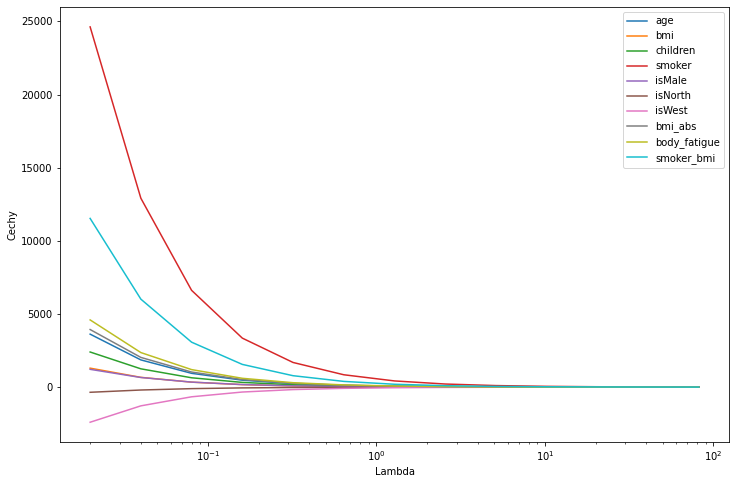

In [296]:
features = ubez_train.columns
# tworzym X oraz y
# przekształcam do numpy array, ponieważ dla typu DataFrame liczyło bardzo długo każdą z iteracji
X = ubez_train.to_numpy()
y = koszty_train.to_numpy().reshape(-1,1)

# normalizacja X
X = X / (np.linalg.norm(X,axis = 0))

lambda_list = list()
w_list = list()

# dodajemy licznik, który jest odpowiedzialny za zwiększanie kary
lambda_counter = 1
while True:
    # w każdej iteracji kara jest coraz większa
    lambda_ = 0.01*2**lambda_counter
    
    e_net = ElasticNet(alpha = lambda_) 
    e_net.fit(X, y)
    
    w = e_net.coef_

    lambda_list.append(lambda_)
    w_list.append(w)
    
    # jeśli zostało mniej niż 'feature_num' nieujemnych współczyników, przerwamy pętlę
    if w.nonzero()[0].shape[0] <= feature_num:
        break

    lambda_counter = lambda_counter + 1

# wykreślenie wykresu
plt.figure(figsize = (12,8))

lambda_array = np.array(lambda_list)
w_matrix = np.array(w_list)

for i in range(features.shape[0]):
    plt.plot(lambda_array, w_matrix[:,i], label = features[i])

plt.xlabel('Lambda')
plt.ylabel('Cechy')
plt.xscale('log')
plt.legend()

# drukowanie końcowe
final_features_elastic_net = features[w.nonzero()[0]]
final_w_elastic_net = regresion(ubez_train[final_features_elastic_net], koszty_train)

display(f"Końcowe lambda: {lambda_}")
display("Współczyniki:", w)
display(f"Final features: {final_features_elastic_net}")

## Określenie najlepszego zestawu cech

In [303]:
def get_rss(X, y, w):
    # Wylicz przewidywaną wartość
    y_pred = np.dot(X, w)
    # Policz błąd
    error = y_pred - y
    # Podnieś błędy do kwadratu i zsumuj je
    return np.dot(error,error.T)    

'Forward stepwise'

['smoker_bmi', 'smoker', 'body_fatigue', 'age']

'Backward stepwise'

Index(['bmi', 'children', 'isNorth', 'isWest'], dtype='object')

'Lasso'

Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')

'Elastic-net'

Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')

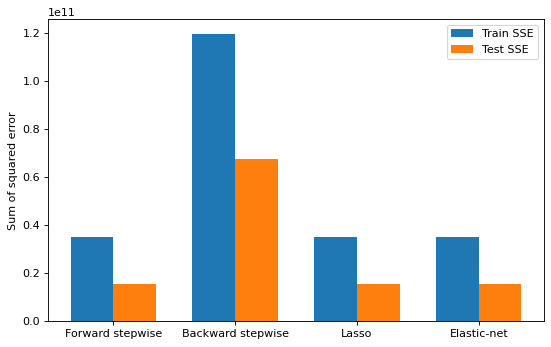

In [309]:
data_list = [
    {
        "comment": "Forward stepwise",
        "features": final_features_forward_stepwise,
        "w": final_w_forward_stepwise
    },
    {
        "comment": "Backward stepwise",
        "features": final_features_backward_stepwise,
        "w": final_w_backward_stepwise
    },
    {
        "comment": "Lasso",
        "features": final_features_lasso,
        "w": final_w_lasso
    },
    {
        "comment": "Elastic-net",
        "features": final_features_elastic_net,
        "w": final_w_elastic_net
    }
] 

labels = list()
train_sse = list()
test_sse = list()

for data in data_list:
    display(data['comment'] , data['features'])
    
    labels.append(data['comment'])
    train_sse.append(get_rss(ubez_train[data['features']], koszty_train, data['w']))
    test_sse.append(get_rss(ubez_test[data['features']], koszty_test, data['w']))

    
# rysowanie wykresu    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
rects1 = ax.bar(x - width/2, train_sse, width, label='Train SSE')
rects2 = ax.bar(x + width/2, test_sse, width, label='Test SSE')

ax.set_ylabel('Sum of squared error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
